In [1]:
from data_clean import remove_221_rows, dropping_no_betting_data, josh_features, fill_f_pm_01m, class_or_rating_average, oli_features
from v2_preprocessor import preprocess_features_v2
import pandas as pd

data  = pd.read_csv("../raw_data/raw_data_v2.2.csv")

data_cleaned = remove_221_rows(data)
data_cleaned = dropping_no_betting_data(data_cleaned)
data_cleaned = josh_features(data_cleaned)
data_cleaned = class_or_rating_average(data_cleaned)
data_cleaned = oli_features(data_cleaned)
data_cleaned = fill_f_pm_01m(data_cleaned)



preprocessed_data = preprocess_features_v2(data_cleaned)

preprocessed_data.to_csv("../raw_data/data_cleaned_and_preprocessed.csv", index=False)

data = pd.read_csv("../raw_data/data_cleaned_and_preprocessed.csv")
data.sort_values(by='f_ko')
data = data[(data['f_pm_01m'] <= 25)]
data = data.reset_index(drop=True)
print(data.shape)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/3196192453.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data  = pd.read_csv("../raw_data/raw_data_v2.2.csv")


first 221 rows removed. New shape = (118354, 116)


/Users/joshstone/code/lucasglanville/and_theyre_off_backend/Preprocessing/data_clean.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_impute] = data[columns_to_impute].apply(impute_row, axis=1)


Cleaned up missing odds. New shape = (118093, 116)
Added Josh features. New shape = (118093, 123)
Added Oli features 2/4. New shape = (118093, 125)
Added Oli features 4/4. New shape = (118093, 127)
number of columns:  128
✅ DROPPED IRRELEVANT COLUMNS
✅ DROPPED ROWS WITH NULL VALUES
✅ WHITESPACE STRIPPED FROM 'f_track'
✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)
✅ WINNERS CODED AS '1', REST '0'
✅ 'f_ko' CONVERTED TO DATETIME
✅ TRACK CONDITIONS ORDINALLY ENCODED
✅ NUMERIC FEATURES MINMAX-SCALED
✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'
✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'
✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES
✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)
number of columns:  88
✅ COLUMN TRANSFORMER ASSEMBLED
⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...
number of columns:  164
✅ DATA PROCESSED WITH SHAPE: (117468, 164)
(85895, 164)


In [2]:
backtest = data[['f_ko','f_id', 'id','f_horse','f_pm_01m', 'linear_target', 'f_place']]

# #X = data[['f_runners','or_rating_vs_avg_race', 'stall_position', 
#           'iv_horse_at', 'iv_trainer_l200r', 'iv_trainer_l50r', 'iv_trainer_l16r', 'iv_trainer_at',
#           'iv_jockey_l200r', 'iv_jockey_l50r', 'iv_jockey_l16r', 'iv_jockey_at',
#           'ae_horse_l10r', 'ae_horse_l5r' , 'ae_horse_l2r' ,'ae_horse_at',
#           'ae_trainer_l200r' , 'ae_trainer_l50r' , 'ae_trainer_l16r' , 'ae_trainer_at',
#           'ae_jockey_l200r' , 'ae_jockey_l50r', 'ae_jockey_l16r' , 'ae_jockey_at' , 'f_dob', 'f_prb_avg', 'pred_isp']]



X = data[['stall_position', 
          'iv_trainer_l200r', 'iv_jockey_l200r',
          'ae_trainer_l200r' ,'ae_jockey_l200r', 
          'iv_trainer_at', 'iv_jockey_at',
          'ae_trainer_at' ,'ae_jockey_at',
          'iv_trainer_l50r', 'iv_jockey_l50r',
          'ae_trainer_l50r' ,'ae_jockey_l50r',
          'iv_trainer_l16r', 'iv_jockey_l16r',
          'ae_trainer_l16r' ,'ae_jockey_l16r','pred_isp']]







y = data["f_place"] #OR 'linear_target'

print(data.shape)
print(X.shape)
print(y.shape)
print(backtest.shape)

#Train = Year 1
#Val = Year 2
#Test = Year 3 (6 months)


(85895, 164)
(85895, 18)
(85895,)
(85895, 7)


In [3]:
X_train = X.iloc[:33243]
X_val = X.iloc[33243:66406]
X_test = X.iloc[66406:]
y_train = y.iloc[:33243]
y_val = y.iloc[33243:66406]
y_test = y.iloc[66406:]
backtest_train = backtest.iloc[:33243]
backtest_val = backtest.iloc[33243:66406]
backtest_test = backtest.iloc[66406:]

In [4]:
X_val.shape

(33163, 18)

In [5]:
#buggy data = 2532754    2021-06-20 03:55:00
                #29406    20-06-14 18:45:00

In [7]:
# convert labels to a one-hot vector
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

# define network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Accuracy, Recall, F1Score
from tensorflow.keras.losses import Poisson
from tensorflow.keras.optimizers import Adam

MLP2 = Sequential()
MLP2.add(InputLayer(input_shape=(18, ))) # input layer
MLP2.add(Dense(32, activation='relu')) # hidden layer 1
MLP2.add(Dense(1, activation='sigmoid')) # output layer


In [8]:
# optimization
MLP2.compile(loss='binary_focal_crossentropy',
            optimizer=Adam(learning_rate = 0.0001),
            metrics=['squared_hinge'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
# train (fit)

es = EarlyStopping(patience=5, restore_best_weights=True)

history = MLP2.fit(X_train, y_train, 
                  epochs=200, batch_size=32, verbose=1,
                  validation_data=(X_val, y_val), callbacks = [es], shuffle = True)

Epoch 1/200
1039/1039 [==============================] - 1s 598us/step - loss: 0.1187 - squared_hinge: 1.7211 - val_loss: 0.1080 - val_squared_hinge: 1.6262
Epoch 2/200
1039/1039 [==============================] - 1s 534us/step - loss: 0.1081 - squared_hinge: 1.6189 - val_loss: 0.1059 - val_squared_hinge: 1.6236
Epoch 3/200
1039/1039 [==============================] - 1s 527us/step - loss: 0.1059 - squared_hinge: 1.6124 - val_loss: 0.1039 - val_squared_hinge: 1.6156
Epoch 4/200
1039/1039 [==============================] - 1s 532us/step - loss: 0.1040 - squared_hinge: 1.6056 - val_loss: 0.1025 - val_squared_hinge: 1.6066
Epoch 5/200
1039/1039 [==============================] - 1s 528us/step - loss: 0.1028 - squared_hinge: 1.5992 - val_loss: 0.1016 - val_squared_hinge: 1.6074
Epoch 6/200
1039/1039 [==============================] - 1s 568us/step - loss: 0.1020 - squared_hinge: 1.5959 - val_loss: 0.1009 - val_squared_hinge: 1.5916
Epoch 7/200
1039/1039 [==============================] - 1

In [10]:
# evaluate performance on test data
a = MLP2.evaluate(X_test, y_test,
                                         verbose=1)
a

610/610 [==============================] - 0s 241us/step - loss: 0.0999 - squared_hinge: 1.5786


[0.09988632798194885, 1.578568696975708]

In [11]:
y_pred = MLP2.predict(X_test)

610/610 [==============================] - 0s 192us/step


In [12]:
y_pred

array([[0.360228  ],
       [0.35601088],
       [0.34305722],
       ...,
       [0.29624146],
       [0.29883674],
       [0.29990363]], dtype=float32)

<Axes: ylabel='Count'>

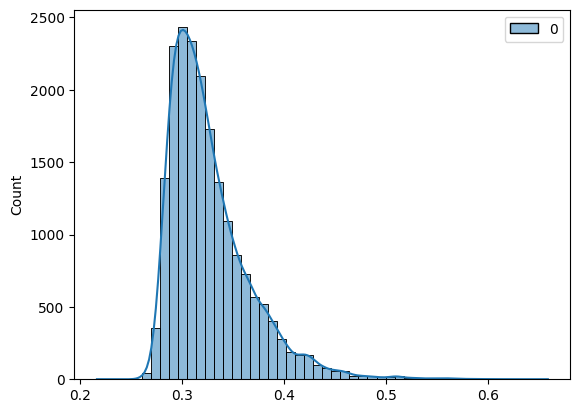

In [13]:
import seaborn as sns
sns.histplot(y_pred, bins = 50, kde=True)

In [14]:
backtest_test['model_preds'] = y_pred
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/2727869485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_preds'] = y_pred
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/2727869485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/2727869485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [15]:
#backtest_test = backtest_test.drop(columns=['f_ko'])
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * backtest_test['race_odds_preds']
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']
backtest_test['model_edge_prop_scaled'] = backtest_test['model_preds_scaled'] / backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/502887811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/502887811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/502887811.py:8: SettingWithCopyWarni

In [16]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0]
above5 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.025]
above10 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.05]
above15 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.075]
above20 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.10]
above30 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.20]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['linear_target'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['linear_target'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['linear_target'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['linear_target'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['linear_target'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['linear_target'].cumsum()

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/1810220086.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfall['cumulative_profit'] = dfall['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/1810220086.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['cumulative_profit'] = df0['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/1810220086.py:20: SettingWithCopyWarning: 
A value is trying to be set 

In [17]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0b = backtest_test[backtest_test['model_edge_basic'] >= 0]
above5b = backtest_test[backtest_test['model_edge_basic'] >= 0.05]
above10b = backtest_test[backtest_test['model_edge_basic'] >= 0.1]
above15b = backtest_test[backtest_test['model_edge_basic'] >= 0.15]
above20b = backtest_test[backtest_test['model_edge_basic'] >= 0.20]
above30b = backtest_test[backtest_test['model_edge_basic'] >= 0.30]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

df0b = above0b
df0b['cumulative_profit'] = df0b['linear_target'].cumsum()

df5b = above5b
df5b['cumulative_profit'] = df5b['linear_target'].cumsum()

df10b = above10b
df10b['cumulative_profit'] = df10b['linear_target'].cumsum()

df15b = above15b
df15b['cumulative_profit'] = df15b['linear_target'].cumsum()

df20b = above20b
df20b['cumulative_profit'] = df20b['linear_target'].cumsum()

df30b = above30b
df30b['cumulative_profit'] = df30b['linear_target'].cumsum()

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/3654561524.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfall['cumulative_profit'] = dfall['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/3654561524.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0b['cumulative_profit'] = df0b['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_23152/3654561524.py:20: SettingWithCopyWarning: 
A value is trying to be se

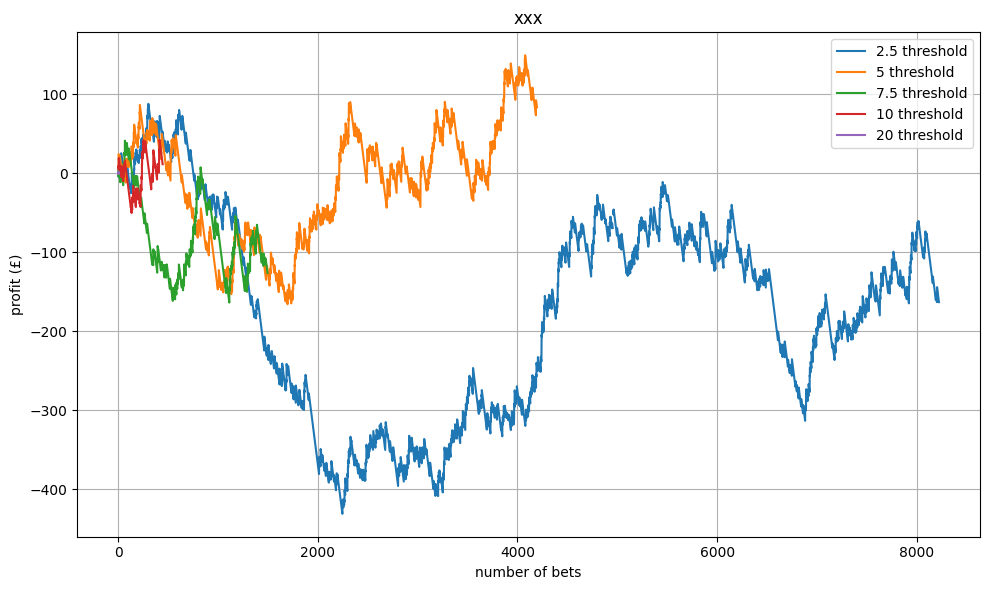

In [18]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='0 threshold')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='2.5 threshold')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='5 threshold')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='7.5 threshold')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='10 threshold')
plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='20 threshold')
#plt.plot(range(1, len(df5b) + 1), df5b['cumulative_profit'], label='5 threshold unscaled')
#plt.plot(range(1, len(df10b) + 1), df10b['cumulative_profit'], label='10 threshold unscaled')
#plt.plot(range(1, len(df15b) + 1), df15b['cumulative_profit'], label='15 threshold unscaled')
#plt.plot(range(1, len(df20b) + 1), df20b['cumulative_profit'], label='20 threshold unscaled')
#plt.plot(range(1, len(df30b) + 1), df30b['cumulative_profit'], label='30 threshold unscaled')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# åplt.hist(backtest_test['model_edge_proportionate'])

In [ ]:
# # Create dataframes of horses above specific proba_difference thresholds

# all_bets = backtest_test
# above0c = backtest_test[backtest_test['model_edge_proportionate'] >= 1]
# above5c = backtest_test[backtest_test['model_edge_proportionate'] >= 1.125]
# above10c = backtest_test[backtest_test['model_edge_proportionate'] >= 1.25]
# above15c = backtest_test[backtest_test['model_edge_proportionate'] >= 1.375]
# above20c = backtest_test[backtest_test['model_edge_proportionate'] >= 1.5]
# above30c = backtest_test[backtest_test['model_edge_proportionate'] >= 1.75]

# # Calculate evolutions of profits for each threshold

# dfall = all_bets
# dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

# df0c = above0c
# df0c['cumulative_profit'] = df0c['linear_target'].cumsum()

# df5c = above5c
# df5c['cumulative_profit'] = df5c['linear_target'].cumsum()

# df10c = above10c
# df10c['cumulative_profit'] = df10c['linear_target'].cumsum()

# df15c = above15c
# df15c['cumulative_profit'] = df15c['linear_target'].cumsum()

# df20c = above20c
# df20c['cumulative_profit'] = df20c['linear_target'].cumsum()

# df30c = above30c
# df30c['cumulative_profit'] = df30c['linear_target'].cumsum()

In [ ]:
# # Create dataframes of horses above specific proba_difference thresholds

# all_bets = backtest_test
# above0d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1]
# above5d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1.05]
# above10d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1.1]
# above15d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1.15]
# above20d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1.2]
# above30d = backtest_test[backtest_test['model_edge_prop_scaled'] >= 1.25]

# # Calculate evolutions of profits for each threshold

# dfall = all_bets
# dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

# df0d = above0d
# df0d['cumulative_profit'] = df0c['linear_target'].cumsum()

# df5d = above5d
# df5d['cumulative_profit'] = df5c['linear_target'].cumsum()

# df10d = above10d
# df10d['cumulative_profit'] = df10c['linear_target'].cumsum()

# df15d = above15d
# df15d['cumulative_profit'] = df15c['linear_target'].cumsum()

# df20d = above20d
# df20d['cumulative_profit'] = df20c['linear_target'].cumsum()

# df30d = above30d
# df30d['cumulative_profit'] = df30c['linear_target'].cumsum()

In [ ]:
# import matplotlib.pyplot as plt
# # Plot
# plt.figure(figsize=(10,6))
# #plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
# #plt.plot(range(1, len(df0d) + 1), df0d['cumulative_profit'], label='1 threshold')
# #plt.plot(range(1, len(df5d) + 1), df5d['cumulative_profit'], label='1.125 threshold')
# plt.plot(range(1, len(df10d) + 1), df10d['cumulative_profit'], label='1.25 threshold')
# plt.plot(range(1, len(df15d) + 1), df15d['cumulative_profit'], label='1.375 threshold')
# plt.plot(range(1, len(df20d) + 1), df20d['cumulative_profit'], label='1.5 threshold')
# plt.plot(range(1, len(df30d) + 1), df30d['cumulative_profit'], label='1.75 threshold')
# #plt.plot(range(1, len(df5c) + 1), df5c['cumulative_profit'], label='1.05 threshold unscaled')
# #plt.plot(range(1, len(df10c) + 1), df10c['cumulative_profit'], label='1.1 threshold unscaled')
# #plt.plot(range(1, len(df15c) + 1), df15c['cumulative_profit'], label='1.15 threshold unscaled')
# #plt.plot(range(1, len(df20c) + 1), df20c['cumulative_profit'], label='1.2 threshold unscaled')
# #plt.plot(range(1, len(df30c) + 1), df30c['cumulative_profit'], label='1.25 threshold unscaled')

# plt.title("xxx")
# plt.xlabel("number of bets")
# plt.ylabel("profit (£)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()